# 최종순위와_광고타겟선정

## 목차 

#### (1) 인도규격 4m 전처리
    - BIS 미설치 정류장 걸러내기
    - 버스정류장 데이터 geodataframe으로 변환
    - 버스 정류장과 최소 거리 인도 찾기
    - 시각화
    - 데이터 병합
#### (2) 구별 인구밀도 
    - 데이터 불러오기
    - 구를 기준으로 합하기
    - 인구 밀도 구하기
    - 정류소 30개를 인구밀도 비율에 따라 나누기
### (3) 정류소별 최종점수 선정
    - 데이터결합
    - 총 3가지의 변수 합산 점수 가중치 정하기
    - 최종 선정 (30개)
        * 1. 순위대로 지정: 특정지역,국소적 밀집현상 발생
        * 2. 해결책1:스마트 정류소별 2km간격 유지(환경부 미세먼지측정소 위치선정 기준)
        * 3. 해결책1+해결책2:구별 인구밀도로 개수 할당
        * 4. 해결책1 vs 해결책1,2: 평가 후 최종선정
    - 평가
### (4) 광고타겟선정
    - 선정된 정류장 주변 유동인구 특성 파악
        * 선정 정류장 기준 반경 500m 버퍼 생성
        * 유동인구 데이터 전처리: 
             위경도별 그룹화한 후, 변수별 평균
             정류소별(30개)로 500m 안에 속하는 유동인구 측정좌표 찾기
    - 유동인구 인원으로 1차 타겟 선정
        * 정류소별 유동인구가 가장 많은 그룹 뽑기
        
    - 유동인구 그룹별 특성을 고려하여 재선정
        * 그룹별 소비성향 파악(수원시 빅데이터 캠퍼스 참고)
             그룹별 소비력=(수원시 전체 그룹별 결제액)/(수원시 전체 그룹별 유동인구)
        * 광고 수용도 반영(논문참고)

In [1]:
import folium
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
import os
from shapely.geometry import Polygon, LineString, Point
from tqdm import tqdm
import shapely

import pathlib
import random
from functools import reduce
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import folium
import shapely
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

from tqdm.notebook import tqdm
import xgboost
import sklearn.cluster
import tensorflow as tf
import pyproj
from fiona.crs import from_epsg
from shapely.ops import cascaded_union
import seaborn as sns


/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from geoband.API import *
GetCompasData('SBJ_2102_002', '1', '1.수원시_버스정류장.csv')
GetCompasData('SBJ_2102_002', '15', '15.수원시_성연령별_유동인구(2020).csv')
GetCompasData('SBJ_2102_002', '16', '16.수원시_요일별_유동인구(2020).csv')
GetCompasData('SBJ_2102_002', '17', '17.수원시_인구정보(고령)_격자.geojson')
GetCompasData('SBJ_2102_002', '18', '18.수원시_인구정보(생산가능)_격자.geojson')
GetCompasData('SBJ_2102_002', '19', '19.수원시_인구정보(유소년)_격자.geojson')
GetCompasData('SBJ_2102_002', '26', '26.수원시_인도(2017).geojson')
GetCompasData('SBJ_2102_002', '29', '29.수원시_법정경계(시군구).geojson')
GetCompasData('SBJ_2102_002', '30', '30.수원시_법정경계(읍면동).geojson')
GetCompasData('SBJ_2102_002', '31', '31.수원시_행정경계(읍면동).geojson')

## (1) 인도규격 4m 전처리

[26.수원시_인도(2017).geojson] 
       
######       - WIDT 칼럼 : 도로폭

######       - QUAL 칼럼 : 인도 제질
    - SWQ000 : 미분류
    - SWQ001 : 아스콘
    - SWQ002 : 콘크리트
    - SWQ003 : 블록
    - SWQ004 : 비포장
    - SWQ005 : 아스콘/블록
    - SWQ999 : 기타
    
######       - BYYN 칼럼 : 인도 자전거도로 유무
    - BYC000 : 미분류
    - BYC001 : 유
    - BYC002 : 무

######       - KIND 칼럼 
    - SWK000 : 미분류
    - SWK001 : 인도
    - SWK002 : 자전거도로

             

In [3]:
df26_4326 = gpd.read_file('26.수원시_인도(2017).geojson')
df26_4326[:3]

UFID  WIDT    QUAL    BYYN    KIND  \
0  1000037612070A00310000000000154767   0.0  SWQ001  BYC001  SWK002   
1  1000037612070A00310000000000154768   0.0  SWQ001  BYC001  SWK002   
2  1000037612070A00310000000000154769   0.0  SWQ001  BYC001  SWK002   

                                            geometry  
0  MULTILINESTRING ((126.98492 37.32861, 126.9849...  
1  MULTILINESTRING ((126.98567 37.32644, 126.9857...  
2  MULTILINESTRING ((126.98459 37.32839, 126.9849...

인도 폭(WIDT)이 0인 데이터 보기

In [4]:
df26_4326[df26_4326['WIDT']==0.0][:3]

UFID  WIDT    QUAL    BYYN    KIND  \
0  1000037612070A00310000000000154767   0.0  SWQ001  BYC001  SWK002   
1  1000037612070A00310000000000154768   0.0  SWQ001  BYC001  SWK002   
2  1000037612070A00310000000000154769   0.0  SWQ001  BYC001  SWK002   

                                            geometry  
0  MULTILINESTRING ((126.98492 37.32861, 126.9849...  
1  MULTILINESTRING ((126.98567 37.32644, 126.9857...  
2  MULTILINESTRING ((126.98459 37.32839, 126.9849...

버스정류장 데이터에서 필요한 feature 가져오기

In [5]:
bus = pd.read_csv('1.수원시_버스정류장.csv')
bus_station = bus[['정류장ID','정류장명','위치(동)','lon','lat','BIS설치여부']]
bus_station

정류장ID     정류장명         위치(동)         lon        lat  BIS설치여부
0     201000313     권선구청   경기도 수원시 서둔동  126.970983  37.256983      1.0
1     201000344    중보들공원    경기도 수원시 평동  126.991029  37.244605      NaN
2     201000345  남수원초등학교  경기도 수원시 세류2동  127.016000  37.251091      1.0
3     201000379   신미주아파트   경기도 수원시 금곡동  126.953845  37.268806      1.0
4     201000055   농수산물시장  경기도 수원시 권선1동  127.029815  37.256755      1.0
...         ...      ...           ...         ...        ...      ...
1174  201000266   구운초등학교   경기도 수원시 구운동  126.978712  37.281431      NaN
1175  228000723    경희대정문  경기도 수원시 영통1동  127.077907  37.247475      NaN
1176  233001574   수영리검사소    경기도 수원시 평동  126.968503  37.232512      NaN
1177  201000123     자혜학교   경기도 수원시 서둔동  126.977880  37.265151      NaN
1178  233001986   수영리검사소    경기도 수원시 평동  126.968669  37.232706      NaN

[1179 rows x 6 columns]

### BIS 미설치 정류장 걸러내기

In [6]:
bus_station.drop(bus_station[bus_station['BIS설치여부']!=1].index, inplace=True)
bus_station.reset_index(inplace=True, drop=True)
bus_station[:3]

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


정류장ID     정류장명         위치(동)         lon        lat  BIS설치여부
0  201000313     권선구청   경기도 수원시 서둔동  126.970983  37.256983      1.0
1  201000345  남수원초등학교  경기도 수원시 세류2동  127.016000  37.251091      1.0
2  201000379   신미주아파트   경기도 수원시 금곡동  126.953845  37.268806      1.0

In [7]:
geom_bus=gpd.points_from_xy(bus_station['lon'],bus_station['lat'])

bus_station.columns

Index(['정류장ID', '정류장명', '위치(동)', 'lon', 'lat', 'BIS설치여부'], dtype='object')

### 버스정류장 데이터 geodataframe으로 변환

##### 5179좌표로 거리를 구하고 4326좌표로 시각화
geodataframe으로 변환

In [8]:
cols=['정류장ID', '정류장명', '위치(동)']
gdf_bus4326=gpd.GeoDataFrame(bus_station[cols],geometry=geom_bus,
                        crs=from_epsg(4326))
gdf_bus4326.head()

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


정류장ID     정류장명         위치(동)                    geometry
0  201000313     권선구청   경기도 수원시 서둔동  POINT (126.97098 37.25698)
1  201000345  남수원초등학교  경기도 수원시 세류2동  POINT (127.01600 37.25109)
2  201000379   신미주아파트   경기도 수원시 금곡동  POINT (126.95384 37.26881)
3  201000055   농수산물시장  경기도 수원시 권선1동  POINT (127.02981 37.25676)
4  201000268    곡반중학교   경기도 수원시 곡선동  POINT (127.03425 37.24608)

 좌표체계 5179변환

In [9]:
gdf_bus=gdf_bus4326.to_crs({'init':'epsg:5179'})
df26=df26_4326.to_crs({'init':'epsg:5179'})

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
bus_location=[[i.x,i.y] for i in gdf_bus.geometry]
bus_location

[[953088.8325470618, 1917697.0594946956],
 [957077.4915156802, 1917021.983755508],
 [951576.6686088945, 1919017.2604015511],
 [958305.7487782871, 1917644.2082207983],
 [958693.5581977137, 1916458.0761120021],
 [950486.9619066603, 1918898.393911618],
 [953717.1521719103, 1923754.0563626047],
 [954835.2728969093, 1920700.333891114],
 [951474.7654632994, 1918703.1196309905],
 [951586.6840123846, 1918707.7694726],
 [951934.6623354071, 1919132.6893666675],
 [953393.5793224536, 1916147.551137755],
 [954800.7589147541, 1920673.3665923544],
 [961343.8229345441, 1918647.8713198693],
 [953672.8344369748, 1915936.3001564604],
 [954653.6540752866, 1917330.0354107695],
 [953440.986599192, 1919016.8050278856],
 [954067.1258248956, 1924220.3276893054],
 [958218.0602011674, 1919984.7411958151],
 [954247.068830497, 1924373.1505773487],
 [958180.6240905719, 1917188.8555614431],
 [958077.5814383092, 1916904.5588029532],
 [953689.6573280577, 1916623.9795600106],
 [959737.7549107805, 1915123.8265398974],
 

In [11]:
bus_location4326=[]
for x,y in zip(bus_station['lon'],bus_station['lat']):
    bus_location4326.append([x,y])

좌표계5179 : 멀티라인 분해

In [12]:
x0, x1,x2 = list(), list(),list()
for i in range(len(df26)):
    for j in range(len(df26['geometry'][i])):
        for _x0, _y0, _x1, _y1 in zip(df26['geometry'][i][j].xy[0][:-1],df26['geometry'][i][j].xy[1][:-1],df26['geometry'][i][j].xy[0][1:],df26['geometry'][i][j].xy[1][1:]):
            x0.append([_x0, _y0])
            x1.append([_x1, _y1])
            x2.append(i)

좌표계4326:멀티라인 분해

In [13]:
x0_4326, x1_4326,x2_4326 = list(), list(),list()
for i in range(len(df26_4326)):
    for j in range(len(df26_4326['geometry'][i])):
        for _x0, _y0, _x1, _y1 in zip(df26_4326['geometry'][i][j].xy[0][:-1],df26_4326['geometry'][i][j].xy[1][:-1],df26_4326['geometry'][i][j].xy[0][1:],df26_4326['geometry'][i][j].xy[1][1:]):
            x0_4326.append([_x0, _y0])
            x1_4326.append([_x1, _y1])
            x2_4326.append([i])

각 라인들 점으로 분해

In [14]:
#좌표계5179:
A= np.array(x0) #시작
B= np.array(x1) #끝

#좌표계4326
A_4326=np.array(x0_4326) #시작
B_4326=np.array(x1_4326) #끝

### 점과 직선 사이의 거리 공식 => 직접 사용x , 벡터연산으로 응용
    def dist(P, A, B):
        area = abs ( (A.x - P.x) * (B.y - P.y) - (A.y - P.y) * (B.x - P.x) )
        AB = ( (A.x - B.x) ** 2 + (A.y - B.y) ** 2 ) ** 0.5
        return ( area / AB )

## 버스 정류장과 최소 거리 인도 찾기
* 5179좌표로 거리 벡터연산=> 최소값 찾고 그 위치 찾기
* 인도(멀티라인)-> 라인으로 쪼개서 작업
* 가장 가까운 라인 찾고, 그 라인이 원래 속해있던 멀티라인 그룹 찾기
* 멀티라인 그룹에 있는 인도 폭 데이터와 결합
* 4326좌표로 시각화해서 확인

버스정류장 위치 뽑아내기(5179)

In [15]:
bus_arr4326=[(i.x,i.y) for i in gdf_bus.geometry] 

거리계산, 최소거리, 최소거리 index 뽑기

In [16]:
res_4326=[]
for i in range(len(bus_arr4326)): 
    A_P=(A-bus_arr4326[i]).T
    B_P=(B-bus_arr4326[i]).T
    area=abs((A_P[0]*B_P[0])-(A_P[1]*B_P[1]))
    AB=((A-B).T[0]**2+(A-B).T[1]**2)**0.5

    #핑크점이랑 가장 가까운 인도 거리(m)와 index
    res_4326.append([(area/AB).min(),(area/AB).argmin()])
res_4326[:3]

[[2.603600266776497, 19381],
 [1.4006766430297026, 45666],
 [12.518126452009197, 10303]]

In [17]:
bus_direct_road_info=[]
road_xy_direct=[]
for i in res_4326:
    road_xy_direct.append([x0_4326[i[1]],x1_4326[i[1]]]) #도로의 4326 좌표
    walkroad_num=x2[i[1]]# 분할된 도로가 원래 몇번째 도로였는지 찾기
    bus_direct_road_info.append([i[0],df26['WIDT'][walkroad_num],walkroad_num])


In [18]:
road_xy_direct[:3]

[[[126.97090935901905, 37.25713448236479],
  [126.9709095610017, 37.25702244728289]],
 [[127.01602265588326, 37.251092717764344],
  [127.01592555029522, 37.25114290000177]],
 [[126.98378450955019, 37.29272864078233],
  [126.98350520011768, 37.293043712577045]]]

## 시각화 

In [19]:
road_start=[i[0] for i in road_xy_direct]
road_end=[i[1] for i in road_xy_direct]

In [20]:
center = [37.26404308610561, 127.02347288584993]
m = folium.Map(location=center, zoom_start=13,tiles='cartodbpositron')

for i in range(len(road_start)):
    folium.Choropleth(
        geo_data=shapely.geometry.LineString([road_start[i], road_end[i]]),
        line_color='yellow',
        line_weight=6,
    ).add_to(m)

for x,y in bus_location4326:
    folium.Choropleth(
        geo_data=shapely.geometry.LineString([[x, y], [x, y]]),
        line_color='blue',
        line_weight=4,
    ).add_to(m)


m


In [21]:
bus_direct_road_info[:3] # 가까운 도보 거리, 도보폭, 도보index

[[2.603600266776497, 0.0, 1499],
 [1.4006766430297026, 4.5, 3698],
 [12.518126452009197, 0.0, 892]]

## 데이터 병합

In [22]:
bus_station['도보거리(m)']=[round(i[0],2) for i in bus_direct_road_info]
bus_station['도보폭']=[i[1] for i in bus_direct_road_info]
bus_station['도보(전체)index']=[i[2] for i in bus_direct_road_info]
bus_station['도보(분리)시작']=road_start
bus_station['도보(분리)끝']=road_end

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [23]:
bus_station.head()

정류장ID     정류장명         위치(동)         lon        lat  BIS설치여부  도보거리(m)  \
0  201000313     권선구청   경기도 수원시 서둔동  126.970983  37.256983      1.0     2.60   
1  201000345  남수원초등학교  경기도 수원시 세류2동  127.016000  37.251091      1.0     1.40   
2  201000379   신미주아파트   경기도 수원시 금곡동  126.953845  37.268806      1.0    12.52   
3  201000055   농수산물시장  경기도 수원시 권선1동  127.029815  37.256755      1.0     1.08   
4  201000268    곡반중학교   경기도 수원시 곡선동  127.034254  37.246081      1.0     0.13   

   도보폭  도보(전체)index                                  도보(분리)시작  \
0  0.0         1499   [126.97090935901905, 37.25713448236479]   
1  4.5         3698  [127.01602265588326, 37.251092717764344]   
2  0.0          892   [126.98378450955019, 37.29272864078233]   
3  3.0         2898   [127.02988659655007, 37.25687617223729]   
4  0.0         5916   [127.03432790360073, 37.24605266249172]   

                                    도보(분리)끝  
0    [126.9709095610017, 37.25702244728289]  
1   [127.01592555029522, 37.25114290000177]  
2  [126.98350520011768, 37.293043712577045]  
3   [127.02984764295991, 37.25677614827447]  
4   [127.03425690763459, 37.24607863349948]

병합한 데이터 저장

In [24]:
bus_station.to_csv('data/도보폭버스정류장.csv',index=False)

## (2) 인구 밀도

### 데이터 불러오기

[2021년1월말기준_인구수.xls] 
[2020년12월말기준_면적.xls]
수원시 통계 데이터 출처

In [25]:
people_num=pd.read_excel('./data/2021년1월말기준_인구수.xls')
people_num.head()

구     동     세대   인구_계   인구_남   인구_여     세대당인구
0  장안구   파장동  10590  23573  11887  11686  2.225968
1  장안구   율천동  19807  43017  22674  20343  2.171808
2  장안구  정자1동  11068  29779  14668  15111  2.690549
3  장안구  정자2동  12522  30060  14755  15305  2.400575
4  장안구  정자3동  14316  42707  21363  21344  2.983166

In [26]:
area = pd.read_excel('./data/2020년12월말기준_면적.xls')
area.head()

구    동        총면적         대지         전         답         임야         기타
0  장안구  파장동  5112553.3   682688.8   66679.8   89771.4  3370470.5   902942.8
1  장안구  정자동  3373145.6  1916324.3   11827.0    8700.0    16821.0  1419473.3
2  장안구  이목동  3520126.2   387449.5  421238.9  244733.0  1805128.2   661576.6
3  장안구  율전동  1928237.6   601202.1  119749.0  125710.0   492964.0   588612.5
4  장안구  천천동  1995697.3   541199.9  190008.8   30135.0    18595.0  1215758.6

### 구를 기준으로 합하기

인구

In [27]:
people_df=people_num.groupby(people_num['구']).sum()
people_df

세대    인구_계    인구_남    인구_여      세대당인구
구                                             
권선구  155206  368686  186125  182561  28.220518
영통구  150117  368633  184894  183739  29.691312
장안구  115743  273324  137599  135725  23.664082
팔달구   86668  175098   88300   86798  19.941839

면적 ( 단위 :㎡)

In [28]:
area_df=area.groupby(area['구']).sum()
area_df

총면적          대지          전          답          임야          기타
구                                                                        
권선구  47182349.6  10832771.1  5132809.9  7242188.9   4984926.2  18989653.5
영통구  27710901.6   8413421.2   572666.4   652693.9   3723999.0  14348121.1
장안구  33342288.9   7069140.1  1595157.5  1042166.8  15560875.0   8074949.5
팔달구  12856138.3   6557845.2   341467.0   281728.7   1185927.4   4489170.0

구 기준으로 merge

In [29]:
df_join = pd.merge(area_df, people_df,on='구')
df_join

총면적          대지          전          답          임야          기타  \
구                                                                           
권선구  47182349.6  10832771.1  5132809.9  7242188.9   4984926.2  18989653.5   
영통구  27710901.6   8413421.2   572666.4   652693.9   3723999.0  14348121.1   
장안구  33342288.9   7069140.1  1595157.5  1042166.8  15560875.0   8074949.5   
팔달구  12856138.3   6557845.2   341467.0   281728.7   1185927.4   4489170.0   

         세대    인구_계    인구_남    인구_여      세대당인구  
구                                               
권선구  155206  368686  186125  182561  28.220518  
영통구  150117  368633  184894  183739  29.691312  
장안구  115743  273324  137599  135725  23.664082  
팔달구   86668  175098   88300   86798  19.941839

### 인구 밀도 구하기

#### 인구밀도: k㎡ 당 인구 수
- 총면적 ㎡ 단위를 인구밀도 k㎡ 단위로 환산

In [30]:
df_join['인구밀도'] = df_join['인구_계']/(df_join['총면적']/(1000*1000))  
df_join

총면적          대지          전          답          임야          기타  \
구                                                                           
권선구  47182349.6  10832771.1  5132809.9  7242188.9   4984926.2  18989653.5   
영통구  27710901.6   8413421.2   572666.4   652693.9   3723999.0  14348121.1   
장안구  33342288.9   7069140.1  1595157.5  1042166.8  15560875.0   8074949.5   
팔달구  12856138.3   6557845.2   341467.0   281728.7   1185927.4   4489170.0   

         세대    인구_계    인구_남    인구_여      세대당인구          인구밀도  
구                                                             
권선구  155206  368686  186125  182561  28.220518   7814.066131  
영통구  150117  368633  184894  183739  29.691312  13302.815091  
장안구  115743  273324  137599  135725  23.664082   8197.517598  
팔달구   86668  175098   88300   86798  19.941839  13619.797478

### 정류소 30개를 인구밀도 비율에 따라 나누기

In [31]:
round(df_join['인구밀도']/sum(df_join['인구밀도'])*30)

구
권선구     5.0
영통구     9.0
장안구     6.0
팔달구    10.0
Name: 인구밀도, dtype: float64

###    권선구     5.0
###    영통구     9.0
###    장안구     6.0
###    팔달구    10.0

## (3) 정류소별 최종점수 선정

### 데이터 결합
 1. category 123 합쳐서 총 점수 만들기
 2. 유효도로폭 1.5m 미달 정류장 제거
    * 정류장 최소 세로폭 2.5m + 1.5m= 4m 미달 정류장 제거

#### cat3:취약계층

In [32]:
cat3=pd.read_csv('data/category3.csv')
cat3['category3_score']=cat3['category3_score']*10
cat3

정류장ID        lat         lon  category3_score
0    201000313  37.256983  126.970983         0.158730
1    201000345  37.251091  127.016000         4.402985
2    201000379  37.268806  126.953845         9.345638
3    201000055  37.256755  127.029815         4.962687
4    201000268  37.246081  127.034254         6.303089
..         ...        ...         ...              ...
923  202000249  37.278865  126.999697         5.849421
924  202000241  37.284316  126.995823         6.428571
925  202000246  37.287994  126.981714         7.046332
926  202000239  37.286663  126.986076         2.947761
927  202000238  37.289506  126.985096         7.451737

[928 rows x 4 columns]

#### cat1: 저감효과

In [33]:
cat1=pd.read_csv('data/category1.csv')
total=pd.merge(cat1[['정류장ID','category1_score']],cat3[['정류장ID','category3_score','lat','lon']],how='inner',on='정류장ID')
total

정류장ID  category1_score  category3_score        lat         lon
0    202000219        10.000000         2.863806  37.267460  127.000934
1    202000224         9.642857         3.488806  37.267314  127.003406
2    202000208         9.285714         2.798507  37.268112  126.999608
3    203000150         8.928571         4.738806  37.244730  127.056186
4    202000106         8.571429         2.873134  37.267365  127.000904
..         ...              ...              ...        ...         ...
914  201000391         0.017077         3.087687  37.242906  126.969126
915  203000308         0.013661         1.944444  37.275450  127.066725
916  203000438         0.010246         1.914683  37.294917  127.056198
917  201000393         0.006831         1.478175  37.241166  126.969778
918  201000326         0.003415         2.420635  37.245513  126.968174

[919 rows x 5 columns]

#### cat2 :유동인구

In [34]:
cat2=pd.read_csv('data/category2_wiith_cluster.csv')
cat2.head()

정류장ID     정류장명     동        lat         lon  category2_score  cluster
0  201000313     권선구청   서둔동  37.256983  126.970983             2.42        0
1  201000345  남수원초등학교  세류2동  37.251091  127.016000             4.26        1
2  201000379   신미주아파트   금곡동  37.268806  126.953845             2.58        0
3  201000055   농수산물시장  권선1동  37.256755  127.029815             3.79        0
4  201000268    곡반중학교   곡선동  37.246081  127.034254             4.21        1

cat1,2,3 합치기

In [35]:
total=pd.merge(total,cat2[['정류장ID','category2_score']],how='inner')
total.head()

정류장ID  category1_score  category3_score        lat         lon  \
0  202000219        10.000000         2.863806  37.267460  127.000934   
1  202000224         9.642857         3.488806  37.267314  127.003406   
2  202000208         9.285714         2.798507  37.268112  126.999608   
3  203000150         8.928571         4.738806  37.244730  127.056186   
4  202000106         8.571429         2.873134  37.267365  127.000904   

   category2_score  
0            10.00  
1            10.00  
2            10.00  
3             5.74  
4            10.00

### 총 3가지의 변수 합산 점수 가중치 정하기

1. category1과 category2는 모든 인구에대한 지표이므로 1의 가중치
2. category3 취약계층은 일부 그룹에만 해당되는 지표이므로 수원시 인구 비율로 가중치 부여, 단 임산부의 특성, 취약계층의 효익이 더 높은 점을 고려하여 가중치 조정
 

3. category3(취약계층) 가중치 조정=> 0.51
    * 유소년, 노인, 임산부 / 전체
    * 임산부는 신생아 통계 7791로 대체, 임산부의 가중치는 2로 둠(아이와 산모)
    * 취약계층의 미세먼지 저감, 편의시설 설치(음성안내 등)은 일반인의 2배의 효용을 가정
    * 전체 비율에 가중치 x2 => category3 취약계층 점수의 가중치


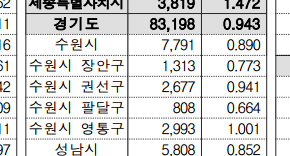
사진출처 : 통계청 '2019 출생통계'
* 수원시 신생아 통계 2019년 총 7791명: 임산부 수 대체

데이터 불러오기

In [36]:
old=gpd.read_file('17.수원시_인구정보(고령)_격자.geojson')
normal=gpd.read_file('18.수원시_인구정보(생산가능)_격자.geojson')
young=gpd.read_file('19.수원시_인구정보(유소년)_격자.geojson')

정렬해서 gid 일치시키기

In [37]:
old.sort_values('gid',inplace=True)
normal.sort_values('gid',inplace=True)
young.sort_values('gid',inplace=True)

인구 비율 고려(임산부 특성, 취약계층 특성 반영)

In [38]:
prop=round((((old.val+young.val).sum()+7791*2)/(old.val+young.val+normal.val).sum())*2,2)
prop 

0.51

### 가중치를 고려한 결합

가중치 부여

In [39]:
total['category3_score']=prop*total['category3_score']

최종 합산

In [40]:
total['tot_score']=total[['category1_score','category3_score','category2_score']].apply(sum,axis=1)

tot_score 총 만점: 25.1점

In [41]:
total.sort_values('tot_score',ascending=False,inplace=True)
total.head(3) 

정류장ID  category1_score  category3_score        lat         lon  \
0  202000219        10.000000         1.460541  37.267460  127.000934   
1  202000224         9.642857         1.779291  37.267314  127.003406   
2  202000208         9.285714         1.427239  37.268112  126.999608   

   category2_score  tot_score  
0             10.0  21.460541  
1             10.0  21.422148  
2             10.0  20.712953

### 도보폭 제한(4m) 적용
* 0m와 결측값은 미측정 도보로 우선 분석에 포함시킨 후 추후에 표시해주기

버스정류장별 가장 가까운 도보와의 거리, 그 도보의 도보폭을 나타내는 데이터

In [42]:
bus_station=pd.read_csv('data/도보폭버스정류장.csv')
bus_station

정류장ID                  정류장명         위치(동)         lon        lat  \
0    201000313                  권선구청   경기도 수원시 서둔동  126.970983  37.256983   
1    201000345               남수원초등학교  경기도 수원시 세류2동  127.016000  37.251091   
2    201000379                신미주아파트   경기도 수원시 금곡동  126.953845  37.268806   
3    201000055                농수산물시장  경기도 수원시 권선1동  127.029815  37.256755   
4    201000268                 곡반중학교   경기도 수원시 곡선동  127.034254  37.246081   
..         ...                   ...           ...         ...        ...   
923  202000249                 화서오거리  경기도 수원시 화서1동  126.999697  37.278865   
924  202000241  숙지공원.화서동굿모닝힐.화서다산도서관  경기도 수원시 화서2동  126.995823  37.284316   
925  202000246           엘지아파트.금강아파트  경기도 수원시 화서2동  126.981714  37.287994   
926  202000239              꽃뫼신동아아파트  경기도 수원시 화서2동  126.986076  37.286663   
927  202000238                 진흥아파트  경기도 수원시 화서2동  126.985096  37.289506   

     BIS설치여부  도보거리(m)  도보폭  도보(전체)index  \
0        1.0     2.60  0.0         1499   
1        1.0     1.40  4.5         3698   
2        1.0    12.52  0.0          892   
3        1.0     1.08  3.0         2898   
4        1.0     0.13  0.0         5916   
..       ...      ...  ...          ...   
923      1.0     7.31  0.0          856   
924      1.0     0.06  3.0          730   
925      1.0     1.97  0.0          828   
926      1.0     1.77  4.3         6287   
927      1.0     0.36  3.0         3579   

                                     도보(분리)시작  \
0     [126.97090935901905, 37.25713448236479]   
1    [127.01602265588326, 37.251092717764344]   
2     [126.98378450955019, 37.29272864078233]   
3     [127.02988659655007, 37.25687617223729]   
4     [127.03432790360073, 37.24605266249172]   
..                                        ...   
923     [126.98755086331293, 37.288494424789]   
924   [126.99598809199928, 37.28424863207626]   
925   [126.98176480773158, 37.28793958991643]   
926   [127.00234192817382, 37.27349073694027]   
927  [127.00675005670725, 37.272346517479136]   

                                      도보(분리)끝  
0      [126.9709095610017, 37.25702244728289]  
1     [127.01592555029522, 37.25114290000177]  
2    [126.98350520011768, 37.293043712577045]  
3     [127.02984764295991, 37.25677614827447]  
4     [127.03425690763459, 37.24607863349948]  
..                                        ...  
923   [126.98769773150438, 37.28832209877347]  
924  [126.99575562622188, 37.284416396860465]  
925     [126.98171999517622, 37.288018856134]  
926   [127.00248089932451, 37.27400083262798]  
927  [127.00665583577722, 37.272501573798856]  

[928 rows x 11 columns]

- 도보와의 거리가 2m 이내인데 도보폭이 4m 미만인 정류장 제외시키기
- 거리의 오차로 도보와의 거리가 2m 이상인 정류장 혹은 폭이 0m인 정류장은
- 가까운 도보의 폭 측정 자료가 없는 정류장이므로 
- 선정 이후에 추가적인 폭 조사 필요성 언급


In [43]:
drop_index = bus_station[(bus_station['도보거리(m)']<2)&((bus_station['도보폭']>0)&(bus_station['도보폭']<4))].index
bus_station = bus_station.drop(drop_index)
bus_station.reset_index(drop=True,inplace=True)

도보폭 미달대상 제외
- 도보와의 최단거리가 2m 이상인 데이터는 미측정으로 간주

In [44]:
new_total=pd.merge(total[['정류장ID','category1_score','category2_score','category3_score','tot_score']],bus_station,
        how='inner',on='정류장ID')
new_total['도보미측정']=np.where(new_total['도보거리(m)']>=2,1,0)
new_total.sort_values(by='tot_score',ascending=False,inplace=True)
new_total.head()

정류장ID  category1_score  category2_score  category3_score  tot_score  \
0  202000219        10.000000             10.0         1.460541  21.460541   
1  202000224         9.642857             10.0         1.779291  21.422148   
2  202000208         9.285714             10.0         1.427239  20.712953   
3  202000106         8.571429             10.0         1.465299  20.036727   
4  202000105         8.214286             10.0         1.199107  19.413393   

        정류장명        위치(동)         lon        lat  BIS설치여부  도보거리(m)   도보폭  \
0  수원역.AK플라자  경기도 수원시 매산동  127.000934  37.267460      1.0     0.88  10.0   
1       매산시장  경기도 수원시 매산동  127.003406  37.267314      1.0     5.68   4.5   
2  수원역.노보텔수원  경기도 수원시 매산동  126.999608  37.268112      1.0     5.67   5.0   
3  수원역.AK플라자  경기도 수원시 매산동  127.000904  37.267365      1.0     0.36   4.0   
4  수원역.AK플라자  경기도 수원시 매산동  127.001484  37.264938      1.0     2.07   3.0   

   도보(전체)index                                 도보(분리)시작  \
0         3386  [127.00107933477582, 37.26737391933207]   
1         3481  [127.0035106623056, 37.267431485799264]   
2         6403  [126.99982092017817, 37.26845271473467]   
3         1714  [126.99837471602807, 37.26532980228734]   
4         6288   [127.0135690535963, 37.27465132621829]   

                                    도보(분리)끝  도보미측정  
0  [127.00098968590345, 37.267406882140854]      0  
1   [127.00321443052881, 37.26731781049561]      1  
2  [126.99992998676657, 37.268273940587115]      1  
3  [126.99839730967291, 37.265334037470126]      0  
4    [127.0136349944186, 37.27479712492614]      1

저장하기

In [45]:
new_total.to_csv('data/리밸런싱전.csv',index=False)

##  최종 선정(30개):

* 1. 순위대로 지정: 특정지역,국소적 밀집현상 발생


* 2. 해결책1:스마트 정류소별 2km간격 유지(환경부 미세먼지측정소 위치선정 기준)


* 3. 해결책1+해결책2:구별 인구밀도로 개수 할당


* 4. 해결책1 vs 해결책1,2: 평가 후 최종선정

In [46]:
new_total=pd.read_csv('data/리밸런싱전.csv')
new_total.head()

정류장ID  category1_score  category2_score  category3_score  tot_score  \
0  202000219        10.000000             10.0         1.460541  21.460541   
1  202000224         9.642857             10.0         1.779291  21.422148   
2  202000208         9.285714             10.0         1.427239  20.712953   
3  202000106         8.571429             10.0         1.465299  20.036727   
4  202000105         8.214286             10.0         1.199107  19.413393   

        정류장명        위치(동)         lon        lat  BIS설치여부  도보거리(m)   도보폭  \
0  수원역.AK플라자  경기도 수원시 매산동  127.000934  37.267460      1.0     0.88  10.0   
1       매산시장  경기도 수원시 매산동  127.003406  37.267314      1.0     5.68   4.5   
2  수원역.노보텔수원  경기도 수원시 매산동  126.999608  37.268112      1.0     5.67   5.0   
3  수원역.AK플라자  경기도 수원시 매산동  127.000903  37.267365      1.0     0.36   4.0   
4  수원역.AK플라자  경기도 수원시 매산동  127.001483  37.264938      1.0     2.07   3.0   

   도보(전체)index                                 도보(분리)시작  \
0         3386  [127.00107933477582, 37.26737391933207]   
1         3481  [127.0035106623056, 37.267431485799264]   
2         6403  [126.99982092017817, 37.26845271473467]   
3         1714  [126.99837471602807, 37.26532980228734]   
4         6288   [127.0135690535963, 37.27465132621829]   

                                    도보(분리)끝  도보미측정  
0  [127.00098968590345, 37.267406882140854]      0  
1   [127.00321443052881, 37.26731781049561]      1  
2  [126.99992998676657, 37.268273940587115]      1  
3  [126.99839730967291, 37.265334037470126]      0  
4    [127.0136349944186, 37.27479712492614]      1

### 방법1: 총 점수 상위 30개(시각화)

상위 30개 추출

In [47]:
soowon_SIGUN=gpd.read_file('29.수원시_법정경계(시군구).geojson')
soowon_DONG=gpd.read_file('30.수원시_법정경계(읍면동).geojson')
top30=new_total[:30]
where=top30[['lat','lon']].values

- 일부 지역에 심각한 밀집현상 발생
- 수원역 인근 정류장 7개-> 분산, 재배치의 필요성

In [48]:
center = [37.26404308610561, 127.02347288584993]
m = folium.Map(location=center, zoom_start=13,tiles='cartodbpositron')


for i in range(30):
    folium.Circle(
        location=where.tolist()[i],
        color='red',
        fill=False
    ).add_to(m)

folium.GeoJson(
    soowon_SIGUN,
    name='soowon_municipalities',
).add_to(m)

m

## 해결책1: 측정소, 버스정류장 위치 중심 1km버퍼 생성

BIS 설치, 도보폭을 만족하는 정류소 기준 버퍼 만들기

In [49]:
base=list(zip(new_total.lon,new_total.lat))

geom_base=gpd.points_from_xy(np.array(base).T[0],np.array(base).T[1])
geom_base[:3]

<GeometryArray>
Length: 3, dtype: geometry

버퍼 반경을 m 거리로 생성하기 위해서 5179좌표계 데이터도 만들기

In [50]:
gdf_base4326=gpd.GeoDataFrame(geometry=geom_base,
                         crs=from_epsg(4326))

gdf_base5179 = gdf_base4326.to_crs({'init':'epsg:5179'})

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


1km 버퍼 생성

In [51]:
buffers5179=gpd.GeoSeries()
for i in range(len(gdf_base5179)):
    buffers5179=buffers5179.append(gpd.GeoSeries(gdf_base5179.iloc[i][0].buffer(1000)))
buffers5179[:3]

0    POLYGON ((956750.891 1918844.870, 956746.076 1...
0    POLYGON ((956970.056 1918827.545, 956965.240 1...
0    POLYGON ((956633.732 1918917.863, 956628.916 1...
dtype: geometry

시각화를 위해서 4326 변환

In [52]:
buffers5179.crs={'init':'epsg:5179'}
buffers4326=buffers5179.to_crs({'init':'epsg:4326'})

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


버퍼 gdf로 만들기

In [53]:
buffers_gpd=gpd.GeoDataFrame(buffers4326)

- 반경 1km 규제 추가(환경부 지침 참고)
- k번째 순위에 있는 정류소가 30개에 선정되기 위해서는
- 이미 순위에 올라간 정류소들의 반경 1km 범위 밖에 존재해야함.

In [54]:
start=[0]
k=1
while len(start)<30:
    for i in range(len(start)):
        if gdf_base4326.iloc[k][0].within(buffers_gpd.iloc[start[i]][0]):break  
        if i==len(start)-1:   
            start.append(k)
    k+=1
start[:10]

[0, 6, 8, 9, 10, 12, 13, 14, 15, 26]

In [55]:
center = [37.26404308610561, 127.02347288584993]
m = folium.Map(location=center, zoom_start=13)

folium.GeoJson(
    gdf_base4326.iloc[start],
    name='soowon_municipalities'
).add_to(m)

folium.GeoJson(
    buffers4326.iloc[start],
    name='soowon_municipalities',
).add_to(m)


folium.GeoJson(
    soowon_SIGUN,
    name='soowon_municipalities',
).add_to(m)

for i in range(len(new_total)):
    folium.Circle(
        new_total[['lat','lon']].values.tolist()[i],
        color='red',
        fill=False
    ).add_to(m)





m

In [56]:
new_total.iloc[start].to_csv('data/0.75cat3.csv',encoding='utf-8-sig',index=False)

## 해결책 2
* 1. 1km 격자 고려
* 2. 구별 스마트정류소 개수 할당
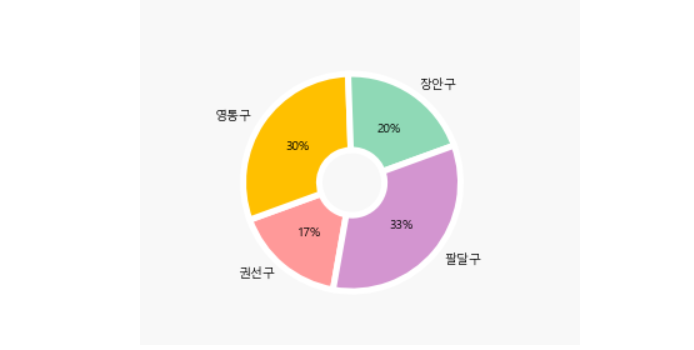

* 각 구별 면적당 인구로 30개의 정류장 배분 (4-2인구밀도 파일 활용 시각화 필요)
* 30 x 각 비중
    1. 권선구     5.0  
    2. 영통구     9.0    
    3. 장안구     6.0  
    4. 팔달구    10.0  

In [57]:
soowon_SIGUN

SIG_CD SIG_KOR_NM                                           geometry
0  41111    수원시 장안구  MULTIPOLYGON (((127.01976 37.35104, 127.02008 ...
1  41113    수원시 권선구  MULTIPOLYGON (((127.03723 37.23684, 127.03679 ...
2  41115    수원시 팔달구  MULTIPOLYGON (((127.03582 37.29361, 127.03644 ...
3  41117    수원시 영통구  MULTIPOLYGON (((127.07484 37.26588, 127.07488 ...

구별 정류장 구분. 각 구에 속하는 정류장 idx 구하기

In [58]:
jangangu_idx=[]
gwonsungu_idx=[]
paldalgu_idx=[]
youngtonggu_idx=[]

for i in range(len(gdf_base4326)):
    busstop=gdf_base4326.iloc[i][0]
    if soowon_SIGUN.iloc[0][2].contains(busstop):
        jangangu_idx.append(i)
    elif soowon_SIGUN.iloc[1][2].contains(busstop):
        gwonsungu_idx.append(i)
    elif soowon_SIGUN.iloc[2][2].contains(busstop):
        paldalgu_idx.append(i)
    else:
        youngtonggu_idx.append(i)

좌표 데이터에 소속 구 열 추가하기

In [59]:
gdf_base4326.loc[jangangu_idx,'구']='장안구'
gdf_base4326.loc[gwonsungu_idx,'구']='권선구'
gdf_base4326.loc[paldalgu_idx,'구']='팔달구'
gdf_base4326.loc[youngtonggu_idx,'구']='영통구'

### 선정하기 (구별 개수 할당,  우선 선정 1km 이내 x)

- 기존과 똑같은 알고리즘에 start에 새롭게 후보가 추가될 때 소속 구 개수가 증가
- 소속 구 개수가 한계치를 넘어서면 그 구에 대해서는 더이상 고려 X

In [60]:
limit_gu={'장안구':6,'권선구':5,'팔달구':10,'영통구':9} # 구별 할당(한계치)
cnt_gu={'장안구':0,'권선구':0,'팔달구':1,'영통구':0}    # 구별 카운트, 1등이 팔달구라 1로 시작함

split_start=[0]
k=1
while len(split_start)<30:
    for i in range(len(split_start)):
        # 이미 특정구에 한계치까지 다 구했으면 바로 break로 for문 탈출, 다음 후보로 넘어감.
        if (cnt_gu[gdf_base4326.iloc[k][1]]>=limit_gu[gdf_base4326.iloc[k][1]])|(gdf_base4326.iloc[k][0].within(buffers_gpd.iloc[split_start[i]][0])):break  
        if i==len(split_start)-1:   
            split_start.append(k)
            cnt_gu[gdf_base4326.iloc[k][1]]+=1
    k+=1

In [61]:
center = [37.26404308610561, 127.02347288584993]
m = folium.Map(location=center, zoom_start=12)

folium.GeoJson(
    gdf_base4326.iloc[split_start],
    name='soowon_municipalities'
).add_to(m)

folium.GeoJson(
    buffers4326.iloc[split_start],
    name='soowon_municipalities',
).add_to(m)


folium.GeoJson(
    soowon_SIGUN,
    name='soowon_municipalities',
).add_to(m)

for i in range(len(new_total)):
    folium.Circle(
        new_total[['lat','lon']].values.tolist()[i],
        color='red',
        fill=False
    ).add_to(m)


m

## 3. 평가(3가지 요소)

* 1km격자=> 반경 500m(도보 이용이 가능한 근린 생활권)
    * 1. 커버면적(1km격자):
    * 2. 커버인구(유동, 버스 승하차):
    * 3. 커버취약인구(거주):

### 1. 합산 다각형 만들기 => 합집합

1. 배분 고려x

In [62]:
model1_4326=gdf_base4326.iloc[:30]
model1_buffer4326=buffers4326.iloc[:30] 
model1_5179=gdf_base5179.iloc[:30]
model1_buffer5179=buffers5179.iloc[:30] #측정소 커버지역 고려 1km 버퍼

2. 1km격자o, 구별할당x

In [63]:
model2_4326=gdf_base4326.iloc[start]
model2_buffer4326=buffers4326.iloc[start]
model2_5179=gdf_base5179.iloc[start]
model2_buffer5179=buffers5179.iloc[start] 

3. 1km격자o, 구별할당o

In [64]:
model3_4326=gdf_base4326.iloc[split_start]
model3_buffer4326=buffers4326.iloc[split_start]
model3_5179=gdf_base5179.iloc[split_start]
model3_buffer5179=buffers5179.iloc[split_start]

### 멀티폴리곤 cascade

수원시 전체 면적: 121킬로미터제곱

In [65]:
suwon_area=121000000

면적 36308055.79580826

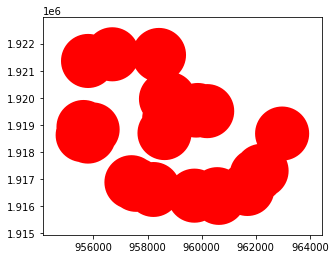

In [66]:
polygons = [i for i in model1_buffer5179]
boundary1 = gpd.GeoSeries(cascaded_union(polygons))
polygons = [i for i in model1_buffer4326]
boundary1_4326 = gpd.GeoSeries(cascaded_union(polygons))


boundary1.plot(color = 'red')
plt.show()

면적 70007267.78649871

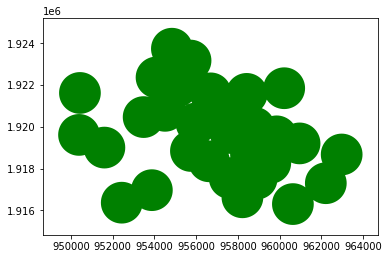

In [67]:
polygons = [i for i in model2_buffer5179]
boundary2 = gpd.GeoSeries(cascaded_union(polygons))

polygons = [i for i in model2_buffer4326]
boundary2_4326 = gpd.GeoSeries(cascaded_union(polygons))

boundary2.plot(color = 'green')
plt.show()

면적 64161165.0406435 

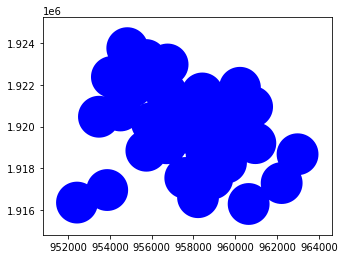

In [68]:
polygons = [i for i in model3_buffer5179]
boundary3 = gpd.GeoSeries(cascaded_union(polygons))

polygons = [i for i in model3_buffer4326]
boundary3_4326 = gpd.GeoSeries(cascaded_union(polygons))

boundary3.plot(color = 'blue')
plt.show()

### 각 멀티폴리곤 면적 계산(area, 5179 좌표계)

2 > 3 >1  순서

In [69]:
area_list=np.array([boundary1.area,boundary2.area,boundary3.area])
area_list*100/suwon_area # model 2가 가장 높은 비율 차지은 비율 차지

array([[30.00665768],
       [57.8572461 ],
       [53.02575623]])

### 모델별 유동인구, 거주인구, 취약인구(거주) 구해보기

#### 1. 유동인구 포함력 보기

In [70]:
df15=pd.read_csv('15.수원시_성연령별_유동인구(2020).csv')
df16=pd.read_csv('16.수원시_요일별_유동인구(2020).csv')
gdf17=gpd.read_file('17.수원시_인구정보(고령)_격자.geojson')
gdf18=gpd.read_file('18.수원시_인구정보(생산가능)_격자.geojson')
gdf19=gpd.read_file('19.수원시_인구정보(유소년)_격자.geojson')

- 총 유동인구(위경도 별, 39415)
- 월별로 결측치 존재 -> sum으로 하면 결측치에 의한 차이가 생김
- mean으로 요약하여 결측치 영향 최소화

In [71]:
float_pop=df16.groupby(['lon','lat']).mean().iloc[:,1:].apply(sum,1)
tot_float7=float_pop.sum() #수원시 일주일 유동인구 총합의 평균
tot_float7

33871172.789987735

In [72]:
tempx=[i[0] for i in float_pop.index]
tempy=[i[1] for i in float_pop.index]
tempx[:3]

[126.92734768, 126.92738865, 126.92739206]

In [73]:
temp=pd.DataFrame(float_pop)[[0]]
temp.reset_index(inplace=True,drop=True)

유동인구 좌표 -> gdf로 변환

In [74]:
geom_float=gpd.points_from_xy(tempx,tempy)
gdf_float=gpd.GeoDataFrame(temp,geometry=geom_float,crs=from_epsg(4326))
gdf_float.head(3)

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


0                    geometry
0   0.534  POINT (126.92735 37.27870)
1  23.378  POINT (126.92739 37.27329)
2  23.300  POINT (126.92739 37.27284)

각 모델 멀티폴리곤에 포함되는 유동인구 총합

In [75]:
covered_float1=0
for i in range(len(gdf_float.geometry)):
    if boundary1_4326.geometry[0].contains(gdf_float.iloc[i,1]):
        covered_float1+=gdf_float.iloc[i,0]
covered_float1

covered_float2=0
for i in range(len(gdf_float.geometry)):
    if boundary2_4326.geometry[0].contains(gdf_float.iloc[i,1]):
        covered_float2+=gdf_float.iloc[i,0]
covered_float2

covered_float3=0
for i in range(len(gdf_float.geometry)):
    if boundary3_4326.geometry[0].contains(gdf_float.iloc[i,1]):
        covered_float3+=gdf_float.iloc[i,0]
covered_float3

26428229.724355288

#### 2. 거주인구 포함력 보기

In [76]:
gdf_base4326.geometry

0      POINT (127.00093 37.26746)
1      POINT (127.00341 37.26731)
2      POINT (126.99961 37.26811)
3      POINT (127.00090 37.26737)
4      POINT (127.00148 37.26494)
                  ...            
722    POINT (126.99080 37.25558)
723    POINT (127.04082 37.30691)
724    POINT (126.97408 37.24298)
725    POINT (126.97909 37.24350)
726    POINT (126.97803 37.31149)
Name: geometry, Length: 727, dtype: geometry

인구 측정 단위 격자 -> 격자 중심점

In [77]:
gdf17.geometry=[i.centroid for i in gdf17.geometry]
gdf18.geometry=[i.centroid for i in gdf18.geometry]
gdf19.geometry=[i.centroid for i in gdf19.geometry]

NAN값 0으로 치환

In [78]:
gdf17.fillna(0,inplace=True)
gdf18.fillna(0,inplace=True)
gdf19.fillna(0,inplace=True)

In [79]:
reside_pop=gdf17.val+gdf18.val+gdf19.val
gdf_reside=gpd.GeoDataFrame(reside_pop,geometry=gdf17.geometry,crs=from_epsg(4326))
gdf_reside

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  


val                    geometry
0      0.0  POINT (126.92645 37.27168)
1      0.0  POINT (126.92758 37.27168)
2      0.0  POINT (126.92757 37.27258)
3      0.0  POINT (126.92757 37.27348)
4      0.0  POINT (126.92756 37.27438)
...    ...                         ...
12495  0.0  POINT (127.08988 37.29399)
12496  0.0  POINT (127.08987 37.29489)
12497  0.0  POINT (127.08987 37.29579)
12498  0.0  POINT (127.08986 37.29759)
12499  0.0  POINT (127.08986 37.29849)

[12500 rows x 2 columns]

#### 각 모델 멀티폴리곤에 포함되는 거주인구 총합

In [80]:
covered_reside1=0
for i in range(len(gdf_reside.geometry)):
    if boundary1_4326.geometry[0].contains(gdf_reside.iloc[i,1]):
        covered_reside1+=gdf_reside.iloc[i,0]
covered_reside1

covered_reside2=0
for i in range(len(gdf_reside.geometry)):
    if boundary2_4326.geometry[0].contains(gdf_reside.iloc[i,1]):
        covered_reside2+=gdf_reside.iloc[i,0]
covered_reside2

covered_reside3=0
for i in range(len(gdf_reside.geometry)):
    if boundary3_4326.geometry[0].contains(gdf_reside.iloc[i,1]):
        covered_reside3+=gdf_reside.iloc[i,0]
covered_reside3

940424.0

In [81]:
covered_reside1

584033.0

### 모델 평가:최종 선정 =>모델 2

면적 커버력 모델2가 1등 수원시의 약 58% 커버

In [82]:
coveredArea_arr=area_list*100/suwon_area
coveredArea_arr=[i[0] for i in coveredArea_arr]
coveredArea_arr

[30.006657682496975, 57.85724610454568, 53.02575623193639]

- 유동인구 커버력 모델2가 1등, 수원시 전체 유동인구의 81% 커버
- 일주일 유동인구 1년 평균

In [83]:
coveredFloat_arr=np.array([covered_float1,covered_float2,covered_float3])
coveredFloat_arr=coveredFloat_arr*100/tot_float7
coveredFloat_arr

array([47.40526301, 81.05990836, 78.02572969])

거주인구 커버력 모델2가 1등 수원시 인구의 약 82% 커버

In [84]:
coveredReside_arr=np.array([covered_reside1,covered_reside2,covered_reside3])
coveredReside_arr=coveredReside_arr*100/1200000
coveredReside_arr

array([48.66941667, 82.37425   , 78.36866667])

### 모델 비교 시각화

In [85]:
modelEvaluation=pd.DataFrame({'model':[1,2,3],
                             'area_cover':coveredArea_arr,
                             'float_cover':coveredFloat_arr.tolist(),
                             'reside_cover':coveredReside_arr.tolist()
                             })

modelEvaluation['model']=pd.Categorical(modelEvaluation['model'])
modelEvaluation

model  area_cover  float_cover  reside_cover
0     1   30.006658    47.405263     48.669417
1     2   57.857246    81.059908     82.374250
2     3   53.025756    78.025730     78.368667

<AxesSubplot:xlabel='model', ylabel='reside_cover'>

<Figure size 432x288 with 0 Axes>

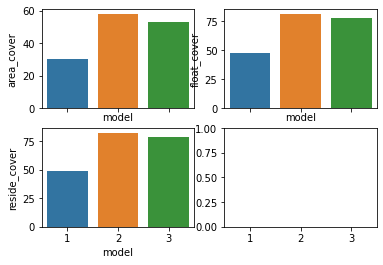

In [86]:
x = np.linspace(0.1, 2, 50)
plt.suptitle('mode_eval')
fig, axes=plt.subplots(2,2, sharex=True)
a=sns.barplot(data=modelEvaluation,x='model',y='area_cover',ax=axes[0,0])
sns.barplot(data=modelEvaluation,x='model',y='float_cover',ax=axes[0,1])
sns.barplot(data=modelEvaluation,x='model',y='reside_cover',ax=axes[1,0])

### 최종 데이터 결합

In [87]:
new_total.head()

정류장ID  category1_score  category2_score  category3_score  tot_score  \
0  202000219        10.000000             10.0         1.460541  21.460541   
1  202000224         9.642857             10.0         1.779291  21.422148   
2  202000208         9.285714             10.0         1.427239  20.712953   
3  202000106         8.571429             10.0         1.465299  20.036727   
4  202000105         8.214286             10.0         1.199107  19.413393   

        정류장명        위치(동)         lon        lat  BIS설치여부  도보거리(m)   도보폭  \
0  수원역.AK플라자  경기도 수원시 매산동  127.000934  37.267460      1.0     0.88  10.0   
1       매산시장  경기도 수원시 매산동  127.003406  37.267314      1.0     5.68   4.5   
2  수원역.노보텔수원  경기도 수원시 매산동  126.999608  37.268112      1.0     5.67   5.0   
3  수원역.AK플라자  경기도 수원시 매산동  127.000903  37.267365      1.0     0.36   4.0   
4  수원역.AK플라자  경기도 수원시 매산동  127.001483  37.264938      1.0     2.07   3.0   

   도보(전체)index                                 도보(분리)시작  \
0         3386  [127.00107933477582, 37.26737391933207]   
1         3481  [127.0035106623056, 37.267431485799264]   
2         6403  [126.99982092017817, 37.26845271473467]   
3         1714  [126.99837471602807, 37.26532980228734]   
4         6288   [127.0135690535963, 37.27465132621829]   

                                    도보(분리)끝  도보미측정  
0  [127.00098968590345, 37.267406882140854]      0  
1   [127.00321443052881, 37.26731781049561]      1  
2  [126.99992998676657, 37.268273940587115]      1  
3  [126.99839730967291, 37.265334037470126]      0  
4    [127.0136349944186, 37.27479712492614]      1

In [88]:
fianl_top30=new_total.iloc[start][['정류장ID','정류장명','category1_score', 'category2_score', 'category3_score', 'tot_score','도보미측정','lon', 'lat']]
fianl_top30.reset_index(inplace=True,drop=True)
fianl_top30.head()

정류장ID                     정류장명  category1_score  category2_score  \
0  202000219                수원역.AK플라자        10.000000            10.00   
1  203000150       그대가프리미어아파트.망포역3번출구         8.928571             5.74   
2  202000053                   우만동4단지         6.891892             6.05   
3  203000123                      영통역         5.675676             5.63   
4  202000016  수원고용복지플러스센터.동수원병원.라마다호텔         4.755245             5.53   

   category3_score  tot_score  도보미측정         lon        lat  
0         1.460541  21.460541      0  127.000934  37.267460  
1         2.416791  17.085362      0  127.056186  37.244730  
2         2.889672  15.831564      1  127.030921  37.292248  
3         4.321309  15.626984      1  127.073923  37.253812  
4         4.894631  15.179876      0  127.035203  37.277633

In [89]:
pd.read_csv('data/dustindex.csv')

정류소ID    total
0     200000001     3731
1     200000002     6846
2     200000003    15568
3     200000004    22547
4     200000005    65702
...         ...      ...
1109  203000449   173068
1110  203000450  3154475
1111  228001883  1421945
1112  233000001   994730
1113  233000592     6155

[1114 rows x 2 columns]

In [90]:
fianl_top30['tot_score'].mean()

12.329677610621756

In [91]:
fianl_top30.to_csv('data/fianl_top30.csv',encoding='utf-8-sig',index=False)

## (4) 광고타겟선정

데이터 불러오기
- 리밸런싱전.csv는 위에서 도로폭, bis로 걸러진 데이터

In [92]:
total_set=pd.read_csv('data/리밸런싱전.csv') 
target_set=pd.read_csv('data/fianl_top30.csv')

gdf 데이터로 변환(4326, 5179 두 개 만들기)

In [93]:
geom_top30=gpd.points_from_xy(target_set.lon,target_set.lat)
cols=['정류장ID', '정류장명', 'category1_score', 'category2_score',
       'category3_score', 'tot_score', '도보미측정']
gdf_target4326=gpd.GeoDataFrame(target_set[cols],geometry=geom_top30,crs=from_epsg(4326))
gdf_target5179=gdf_target4326.to_crs({'init':'epsg:5179'})
gdf_target5179.head()

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


정류장ID                     정류장명  category1_score  category2_score  \
0  202000219                수원역.AK플라자        10.000000            10.00   
1  203000150       그대가프리미어아파트.망포역3번출구         8.928571             5.74   
2  202000053                   우만동4단지         6.891892             6.05   
3  203000123                      영통역         5.675676             5.63   
4  202000016  수원고용복지플러스센터.동수원병원.라마다호텔         4.755245             5.53   

   category3_score  tot_score  도보미측정                        geometry  
0         1.460541  21.460541      0  POINT (955750.891 1918844.870)  
1         2.416791  17.085362      0  POINT (960637.998 1916298.893)  
2         2.889672  15.831564      1  POINT (958423.385 1921581.328)  
3         4.321309  15.626984      1  POINT (962215.668 1917299.204)  
4         4.894631  15.179876      0  POINT (958794.882 1919958.023)

5179 좌표계로 top30 정류소 별 1km 버퍼 생성

In [94]:
buffers5179=gpd.GeoSeries()
for i in range(len(gdf_target5179)):
    buffers5179=buffers5179.append(gpd.GeoSeries(gdf_target5179.geometry[i].buffer(1000)))
buffers5179[:3]


buffers4326=gpd.GeoSeries()
for i in range(len(gdf_target4326)):
    buffers4326=buffers4326.append(gpd.GeoSeries(gdf_target4326.geometry[i].buffer(1000)))
buffers4326[:3]

0    POLYGON ((1127.001 37.267, 1122.186 -60.750, 1...
0    POLYGON ((1127.056 37.245, 1122.241 -60.772, 1...
0    POLYGON ((1127.031 37.292, 1122.216 -60.725, 1...
dtype: geometry

### 선정된 정류장 주변 유동인구 특성파악

In [95]:
df15=pd.read_csv('15.수원시_성연령별_유동인구(2020).csv')
df16=pd.read_csv('16.수원시_요일별_유동인구(2020).csv')

ddmuniBorder=gpd.read_file('30.수원시_법정경계(읍면동).geojson')
lawBorder=gpd.read_file('31.수원시_행정경계(읍면동).geojson')

위치별로 개수 다름 => 일자별 위치별 결측 존재, 총 합보다는 평균으로 접근

In [96]:
mean_15=df15.groupby(['lon','lat']).mean()
mean_16=df16.groupby(['lon','lat']).mean()

#### 유동인구 데이터 변형

    * 위치별 평균
    * 성별,연령별 위치별 평균 => gdf 변환
    * 요일별 위치별 평균 => gdf 변환
    * 멀티폴리곤에 속하는지 여부로 데이터 1차 여과
    * 각 정류소별 반경500m 버퍼에 속하는 데이터들의 총합 만들기.

위치별 평균으로 데이터 변환

In [97]:
mean_15['lon']=[i[0] for i in mean_15.index]
mean_15['lat']=[i[1] for i in mean_15.index]
mean_15.reset_index(inplace=True,drop=True)

mean_16['lon']=[i[0] for i in mean_16.index]
mean_16['lat']=[i[1] for i in mean_16.index]
mean_16.reset_index(inplace=True,drop=True)

성별, 연령별

In [98]:
geom_sexage4326=gpd.points_from_xy(mean_15.lon,mean_15.lat)
gdf_sexage4326=gpd.GeoDataFrame(mean_15.iloc[:,1:],geometry=geom_sexage4326,
                crs=from_epsg(4326))
gdf_sexage5179=gdf_sexage4326.to_crs({'init':'epsg:5179'})

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


요일별

In [99]:
geom_weekday4326=gpd.points_from_xy(mean_16.lon,mean_16.lat)
gdf_weekday4326=gpd.GeoDataFrame(mean_16.iloc[:,1:],geometry=geom_weekday4326,
                crs=from_epsg(4326))
gdf_weekday5179=gdf_weekday4326.to_crs({'init':'epsg:5179'})

멀티폴리곤 만들기

In [100]:
polygons = [i for i in buffers4326]
boundary4326 = gpd.GeoSeries(cascaded_union(polygons))

데이터셋 축소: 멀티폴리곤에 속하는 요소 추리기

In [101]:
sexage_idx=[]
weekdays_idx=[]
for i in range(len(gdf_sexage4326)):
    if boundary4326.geometry[0].contains(gdf_sexage4326.geometry[i]):
        sexage_idx.append(i)
    if boundary4326.geometry[0].contains(gdf_weekday4326.geometry[i]):
        weekdays_idx.append(i)

gdf_sexage5179=gdf_sexage5179.iloc[sexage_idx]
gdf_sexage5179.reset_index(inplace=True,drop=True)
gdf_weekday5179=gdf_weekday5179.iloc[weekdays_idx]
gdf_weekday5179.reset_index(inplace=True,drop=True)

### 유동인구 인원으로 1차 타겟 선정

총 30개의 버퍼(거리라서 5179사용), 각 버퍼에 속하는 인구 특성 찾기

In [102]:
total_idx_sexage=[]
total_idx_weekdays=[]

for i in range(30):
    each_idx=[]
    for j in range(len(gdf_sexage5179)):
        if buffers5179.geometry.iloc[i].contains(gdf_sexage5179.geometry[j]):
            each_idx.append(j)
    total_idx_sexage.append(each_idx)
    each_idx=[]
    for k in range(len(gdf_weekday5179)):
        if buffers5179.geometry.iloc[i].contains(gdf_weekday5179.geometry[k]):
            each_idx.append(k)
    total_idx_weekdays.append(each_idx)

정류소 기준 반경500m 이내,인근지역 성,연령별 유동인구 연 평균 총합 데이터

In [103]:
sexage_info=[]
for i in total_idx_sexage:
    sexage_info.append(pd.DataFrame(gdf_sexage5179.iloc[i,:-3]).apply(sum,0))
sexage_info_df=pd.concat(sexage_info,axis=1).T
sexage_info_df[:3]

MAN_FLOW_POP_CNT_10G  MAN_FLOW_POP_CNT_20G  MAN_FLOW_POP_CNT_30G  \
0           6119.511848          25815.023815          26662.373801   
1           8009.853028          15911.417652          32234.822124   
2           3300.606676          10508.744238          17242.607553   

   MAN_FLOW_POP_CNT_40G  MAN_FLOW_POP_CNT_50G  MAN_FLOW_POP_CNT_60GU  \
0          28387.969948          29563.714436           29602.536964   
1          34773.033452          24803.050919           15052.139735   
2          21417.122508          20473.623734           18307.254147   

   WMAN_FLOW_POP_CNT_10G  WMAN_FLOW_POP_CNT_20G  WMAN_FLOW_POP_CNT_30G  \
0            7051.035311           26027.195692           18980.348155   
1            8643.858616           14022.982088           23553.064472   
2            3659.223615            8639.999384           10256.652885   

   WMAN_FLOW_POP_CNT_40G  WMAN_FLOW_POP_CNT_50G  WMAN_FLOW_POP_CNT_60GU  
0           19981.346152           20810.990974            19485.534772  
1           23410.425758           16607.612949            10302.246033  
2           12902.191922           13338.844358            12949.337601

##### 정류소별 유동인구가 가장 큰 집단 구하기
* 대부분 40 ~ 60대 남성
* 조정 필요: 
    1. 그룹별 소비성향 파악 
    2. 그룹별 광고 수용도 파악

In [104]:
sexage_info_df.apply(lambda x:sexage_info_df.columns[x==max(x)],1)

0     Index(['MAN_FLOW_POP_CNT_60GU'], dtype='object')
1      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
2      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
3      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
4      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
5      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
6      Index(['MAN_FLOW_POP_CNT_50G'], dtype='object')
7      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
8      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
9      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
10     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
11     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
12     Index(['MAN_FLOW_POP_CNT_50G'], dtype='object')
13     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
14     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
15     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
16    Index(['MAN_FLOW_POP_CNT_60GU'], dtype='object')
17     Index(['MAN_FLOW_POP_CNT_50G'], dtype='object')
18     Ind

정류소 기준 반경500m 이내,인근지역 요일별 유동인구 연 평균 총합 데이터

In [105]:
weekdays_info=[]
for i in total_idx_sexage:
    weekdays_info.append(pd.DataFrame(gdf_weekday5179.iloc[i,:-3]).apply(sum,0))
weekdays_info_df=pd.concat(weekdays_info,axis=1).T
weekdays_info_df[:4]

FLOW_POP_CNT_MON  FLOW_POP_CNT_TUS  FLOW_POP_CNT_WED  FLOW_POP_CNT_THU  \
0     200274.083709     202646.719031     203011.379725     203505.286269   
1     206086.200100     210098.338760     208468.838512     208911.077918   
2     150706.006442     153535.251321     152910.122510     153418.930499   
3     171016.216771     175270.137401     174572.022232     175299.045172   

   FLOW_POP_CNT_FRI  FLOW_POP_CNT_SAT  FLOW_POP_CNT_SUN  
0     215956.867170     209190.566610     174415.720737  
1     209417.008429     174843.485417     151118.394530  
2     157628.382759     146635.059871     121873.198168  
3     177349.830081     157346.356838     139756.018810

* 정류소 별 유동인구가 가장 많은 날 구하기
* 대부분이 금요일에 가장 많음

In [106]:
weekdays_info_df.apply(lambda x:weekdays_info_df.columns[x==max(x)],1)

0     Index(['FLOW_POP_CNT_FRI'], dtype='object')
1     Index(['FLOW_POP_CNT_TUS'], dtype='object')
2     Index(['FLOW_POP_CNT_FRI'], dtype='object')
3     Index(['FLOW_POP_CNT_FRI'], dtype='object')
4     Index(['FLOW_POP_CNT_FRI'], dtype='object')
5     Index(['FLOW_POP_CNT_FRI'], dtype='object')
6     Index(['FLOW_POP_CNT_FRI'], dtype='object')
7     Index(['FLOW_POP_CNT_TUS'], dtype='object')
8     Index(['FLOW_POP_CNT_FRI'], dtype='object')
9     Index(['FLOW_POP_CNT_FRI'], dtype='object')
10    Index(['FLOW_POP_CNT_FRI'], dtype='object')
11    Index(['FLOW_POP_CNT_FRI'], dtype='object')
12    Index(['FLOW_POP_CNT_FRI'], dtype='object')
13    Index(['FLOW_POP_CNT_TUS'], dtype='object')
14    Index(['FLOW_POP_CNT_FRI'], dtype='object')
15    Index(['FLOW_POP_CNT_FRI'], dtype='object')
16    Index(['FLOW_POP_CNT_FRI'], dtype='object')
17    Index(['FLOW_POP_CNT_FRI'], dtype='object')
18    Index(['FLOW_POP_CNT_FRI'], dtype='object')
19    Index(['FLOW_POP_CNT_FRI'], dtype='object')


### 유동인구 그룹별 특성을 고려하여 재선정

* 그룹별 소비성향 가중치
* 남녀별 광고 수용도에 따른 가중치

#### 그룹별 소비성향 반영
* 수원시 전체 소비성향, 데이터: 수원시 빅데이터 캠퍼스
* 소비금액/ 유동인구로 소비력 파악하기
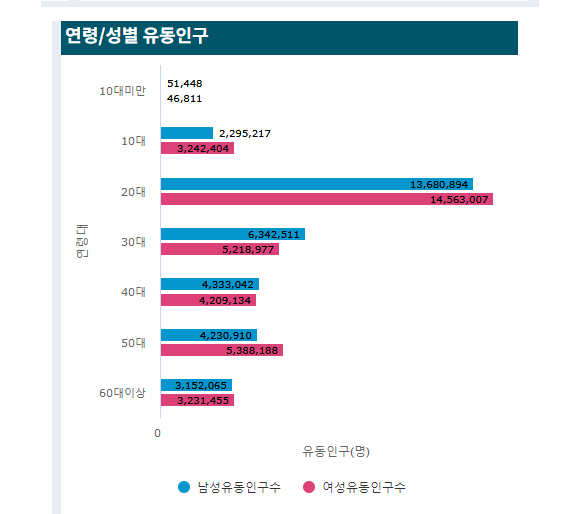

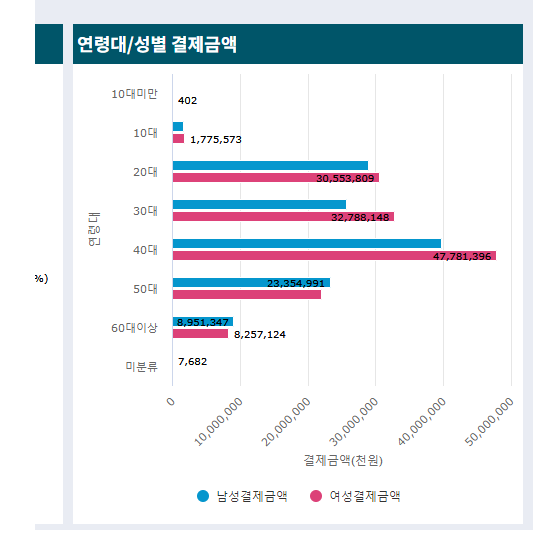

각 그룹별 가중치 구하기: 수원시 전체(2019.04~2021.01) 총 지역화폐 결제액/총 유동인구

In [107]:
suwon_float=np.array([2295217,13680894,6342511,4333042,4230910,3152065,3242404,14563007,5218977,4209134,5388188,3231455])
suwon_consume=np.array([1651442,28975351,25693728,39625603,23354991,8951347,1775573,30553809,32788148,47781396,21998402,8257124])
consume_power=suwon_consume/suwon_float
consume_power

array([ 0.71951454,  2.1179428 ,  4.05103405,  9.14498475,  5.52008693,
        2.83983579,  0.54761004,  2.0980426 ,  6.28248563, 11.35183532,
        4.0827087 ,  2.5552341 ])

가중치 결합 이후 결과보기

In [108]:
sexage_info_df_weighted=sexage_info_df*consume_power
sexage_info_df_weighted.apply(lambda x:sexage_info_df_weighted.columns[x==max(x)],1)

0      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
1      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
2      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
3     Index(['WMAN_FLOW_POP_CNT_40G'], dtype='object')
4      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
5     Index(['WMAN_FLOW_POP_CNT_40G'], dtype='object')
6      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
7     Index(['WMAN_FLOW_POP_CNT_40G'], dtype='object')
8      Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
9     Index(['WMAN_FLOW_POP_CNT_40G'], dtype='object')
10    Index(['WMAN_FLOW_POP_CNT_40G'], dtype='object')
11     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
12     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
13     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
14     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
15     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
16     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
17     Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
18     Ind

#### 광고 수용도 반영

* 옥외광고의 경우 여성이 남성보다 광고 수용도가 높음.
* 2010.인구학적 요인과 디자인 요소가 옥외광고 효과에 미치는 영향
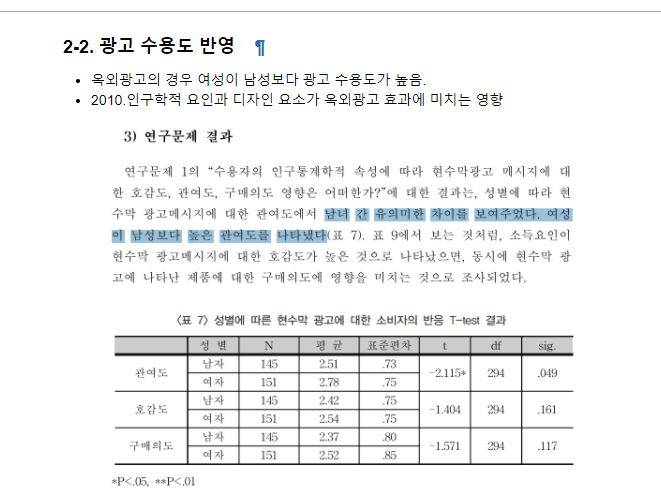

* 위 결과에서 관여도가 가장 유의한 결과를 보임
* 관여도를 비중으로 삼아서 남자 2.51, 여자 2.78 각각 곱하기

In [109]:
weights=np.array([2.51,2.51,2.51,2.51,2.51,2.51,2.78,2.78,2.78,2.78,2.78,2.78])
sexage_info_df_weighted2=sexage_info_df_weighted*weights

commercial_target=sexage_info_df_weighted2.apply(lambda x:sexage_info_df_weighted2.columns[x==max(x)],1)
commercial_target[:3]

0    Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
1    Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
2    Index(['MAN_FLOW_POP_CNT_40G'], dtype='object')
dtype: object

In [114]:
sexage_info_df_weighted2.to_csv('data/commercial_weighted2.csv',index=False)

### 결합하고 제출파일 만들기

In [115]:
target_set=pd.read_csv('data/fianl_top30.csv')
commercial_info=pd.read_csv('data/commercial_weighted2.csv')

# 광고 효과가 가장 큰 집단 뽑아서 commercial_target 변수에 값 넣기
commercial_target=commercial_info.apply(lambda x:commercial_info.columns[x==max(x)],1)
commercial_target=np.array([i[0] for i in commercial_target])

# 광고 타겟 이름 변경해주기
target_set['광고Target층']=np.where(commercial_target=='MAN_FLOW_POP_CNT_40G','40대 남성',np.where(commercial_target=='WMAN_FLOW_POP_CNT_40G','40대 여성',0))
target_set[:3]

정류장ID                정류장명  category1_score  category2_score  \
0  202000219           수원역.AK플라자        10.000000            10.00   
1  203000150  그대가프리미어아파트.망포역3번출구         8.928571             5.74   
2  202000053              우만동4단지         6.891892             6.05   

   category3_score  tot_score  도보미측정         lon        lat 광고Target층  
0         1.460541  21.460541      0  127.000934  37.267460    40대 남성  
1         2.416791  17.085362      0  127.056186  37.244730    40대 남성  
2         2.889672  15.831564      1  127.030921  37.292248    40대 남성

submission 파일 만들기

In [116]:
submission=pd.DataFrame()
submission['설치순위']=target_set.index+1
submission[['정류장명','정류장ID','X좌표(경도)','Y좌표(위도)','광고Target층','비고']]=target_set[['정류장명','정류장ID','lon','lat','광고Target층','도보미측정']]
submission.비고=np.where(submission.비고==0,'','도보폭재측정')
submission[:30]

설치순위                                  정류장명      정류장ID     X좌표(경도)  \
0      1                             수원역.AK플라자  202000219  127.000934   
1      2                    그대가프리미어아파트.망포역3번출구  203000150  127.056186   
2      3                                우만동4단지  202000053  127.030921   
3      4                                   영통역  203000123  127.073923   
4      5               수원고용복지플러스센터.동수원병원.라마다호텔  202000016  127.035203   
5      6                                선일초등학교  201000199  127.028894   
6      7                      KT수원지사.국민연금북수원지사  200000093  127.011444   
7      8                                구법원사거리  203000068  127.047218   
8      9                                중소기업은행  202000011  127.033395   
9     10                               황골벽산아파트  203000120  127.082425   
10    11                      정자3동주민센터.정자동중심상가  200000111  126.993411   
11    12                                 세권사거리  201000007  127.021982   
12    13               수일여중.한빛현요양병원.경기도융합과학교육원  200000195  127.000471   
13    14                       광교호수공원입구.원천교사거리  203000071  127.059640   
14    15                               오목천동사거리  201000164  126.963690   
15    16                                경기소방본부  203000164  127.036513   
16    17                       병무청입구.고등동행정복지센터  202000201  127.003885   
17    18                              구운동강남아파트  201000189  126.975261   
18    19                        고색역.고색초교.태산아파트  201000023  126.979930   
19    20                        팔달구청.화성행궁.수원성지  202000231  127.016262   
20    21  경기도인재개발원.경기연구원.경기도평생교육진흥원.경기도가족여성연구원  200000075  126.990346   
21    22                               2001아울렛  202000051  127.022371   
22    23                        당수동인정.한라.쌍용아파트  201000240  126.940748   
23    24                                신미주아파트  201000095  126.954140   
24    25                     매탄고등학교.그린빌주공1.2단지  203000026  127.043866   
25    26                        유천교.세류1동주민센터입구  201000084  127.010755   
26    27                                 천천중학교  200000101  126.982127   
27    28                        수원광교박물관.광교카페거리  203000046  127.051198   
28    29                          화서역.화서2동주민센터  202000235  126.986807   
29    30                      칠보마을5단지.모아미래도아파트  201000413  126.940393   

      Y좌표(위도) 광고Target층      비고  
0   37.267460    40대 남성          
1   37.244730    40대 남성          
2   37.292248    40대 남성  도보폭재측정  
3   37.253812    40대 여성  도보폭재측정  
4   37.277633    40대 여성          
5   37.247558    40대 여성          
6   37.292391    40대 남성  도보폭재측정  
7   37.273968    40대 여성          
8   37.266237    40대 남성  도보폭재측정  
9   37.266250    40대 여성          
10  37.295401    40대 여성  도보폭재측정  
11  37.255811    40대 남성          
12  37.306521    40대 남성  도보폭재측정  
13  37.270955    40대 남성          
14  37.244951    40대 남성  도보폭재측정  
15  37.255604    40대 여성          
16  37.279439    40대 남성          
17  37.281989    40대 여성          
18  37.250431    40대 남성          
19  37.283901    40대 남성          
20  37.311592    40대 남성          
21  37.275304    40대 여성  도보폭재측정  
22  37.292256    40대 남성  도보폭재측정  
23  37.268710    40대 남성  도보폭재측정  
24  37.262468    40대 남성          
25  37.263036    40대 남성          
26  37.299151    40대 여성          
27  37.294768    40대 남성  도보폭재측정  
28  37.284739    40대 여성          
29  37.274125    40대 여성  도보폭재측정

In [117]:
submission.to_csv('data/submission.csv',index=False)